# Preprocessing Images

## The Data

We scrape data from Zillow and filter it down into images and prices. We use Zillow's estimated price at the time of scraping (called `zestimate`) as our target labels. The scraped data is contained in the `data/raw` directory. We will clean this data such that we have a directory of images for each property. We will also create a `csv` that holds a mapping from the id for each home to its price category.

We have about 3000 houses and 100,000 photos. We download each photo as a `webp` file with a width of `1024` pixels, leading to a total of 10GBs of data.

### Data Directory Structure

Our raw data is contained in the `data/raw` directory which holds `<zpid>.json` files for each property, where `zpid` is a unique identifier for each property from Zillow. Each json contains the price for each property plus a list of images.

We will convert this into a `data/cleaned` directory which holds a single directory for each image containing its images, as well as a `meta.csv` which maps `zip`s to our price categories.

## Preprocessing

We first preprocess our data into something a CNN could actually work with. We have a large JSON file containing the ID, price, and a set of URLs for each house (3044 houses). We then fetch the images contained in each of these URLs and preprocess (vectorize) them into tensors, and then we resize and normalize them. We will resize our images to be a standard (224, 224, 3) tensor, meaning a 224 x 224 pixes where each pixel is an RGB vector.

Since we are using a simple CNN, it's difficult to handle multiple images for each house, since we need feature vectors of fixed size. We could concatenate the images into large tensors, and pad the tensors for houses with less images so that they are all the same size. However, we will stick to a single image per house at first, and then venture into multiple images per house with a Transformer model, which can handle feature vectors of varying sizes. In order to not "waste" data, we will essentially treat each image of a house as its own house, meaning a house with 10 images will become ten training points each with the same price label.

We format our targets/labels using a zero-indexed integer encoding (cheap = 0, average = 1, expensive = 2). 

## Data Loading

We will use Pytorch's `DataLoader` to load our training data in batches. This allows us to perform mini-batched gradient descent, while also preventing us from having to load the entire dataset into memory or having to train on a single data point at a time.

The `DataLoader` allows us to define a processing (or `transformer`) step at the time of loading. This transformation will apply our resizing and normalization.

In [19]:
import os
import json
from typing import Tuple
import requests as req
from pprint import pprint as pp
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

plt.style.use("ggplot")

BASE_DIR = os.path.dirname(os.path.abspath(__name__))
DATA_DIR = os.path.join(BASE_DIR, "data")
RAW_DIR = os.path.join(DATA_DIR, "raw")
CLEANED_DIR = os.path.join(DATA_DIR, "cleaned")

# Map from Encoding to Category and vice-versa
etoc = {
    0: "cheap",
    1: "average",
    2: "expensive",
}
ctoe = {v: k for k, v in etoc.items()}

# Converting Messy JSONs to a Structured Data Directory

We convert the messy jsons from our scraping into our desired image/price dataset.

In [2]:
# Example of the data
sample = os.path.join(RAW_DIR, os.listdir(RAW_DIR)[0])
with open(sample, "r") as f:
    sample = json.load(f)
pp(sample, depth=1)

{'appGip': True,
 'assetPrefix': 'https://www.zillowstatic.com/s3/shopper-platform',
 'buildId': 'oOwxlgzKeLBQsvG-A2Oun',
 'customServer': True,
 'gip': True,
 'isFallback': False,
 'page': '/render/[...urlPath]',
 'props': {...},
 'query': {...},
 'runtimeConfig': {...},
 'scriptLoader': [],
 'zestimateHistory': []}


In [3]:
# Extracting the price and images
def unnest(raw_data):
    return list(
        raw_data["props"]["pageProps"]["componentProps"]["gdpClientCache"].values()
    )[0]["property"]


sample = unnest(sample)
zestimate = sample["zestimate"]
original_photos = sample["originalPhotos"]

print(f"Zillow Estimate: {zestimate}")
print(f"Original photos:")
pp(original_photos, depth=2)

Zillow Estimate: 248800
Original photos:
[{'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '', 'mixedSources': {...}},
 {'caption': '',

In [24]:
def get_url(original_photo: dict, width=1024) -> dict:
    """
    Get the link to the photo with the specified width,
    ideally a webp image.

    Raise if the expected format not found (just because
    I don't know if that ever happens and I want to find out).
    """
    assert set(original_photo.keys()) == set(
        ["caption", "mixedSources"]
    )  # just checking

    photo = original_photo["mixedSources"]

    try:
        photo = photo["webp"]  # better for compression/downloading speed
    except KeyError:
        raise ValueError("No webp version found.")

    for d in photo:
        url = d["url"]
        w = d["width"]
        if int(w) == width:
            return url

    raise ValueError(f"No photo with width={width} found")


def get_urls(original_photos: list, width=1024) -> list:
    return [get_url(photo, width) for photo in original_photos]


urls = get_urls(sample["originalPhotos"])
urls

['https://photos.zillowstatic.com/fp/7ff4b8ab72528499acc6f50ef4bc7c9c-o_a.webp',
 'https://photos.zillowstatic.com/fp/3996115a88c81440389768f3a8d2ce81-o_a.webp',
 'https://photos.zillowstatic.com/fp/33f655801898a16673f19dd305f52ddc-o_a.webp',
 'https://photos.zillowstatic.com/fp/c723a299d84695115005ebcd5f0b3389-o_a.webp',
 'https://photos.zillowstatic.com/fp/f2dd9d0010e5782cfa39a7f69a9caf92-o_a.webp',
 'https://photos.zillowstatic.com/fp/3ad0bc4985acb199889f21b37b685749-o_a.webp',
 'https://photos.zillowstatic.com/fp/c6096dc117e9128e0f6f24d9d8c6942d-o_a.webp',
 'https://photos.zillowstatic.com/fp/c6cfef5581deee56dd34fe6759a3919e-o_a.webp',
 'https://photos.zillowstatic.com/fp/9168cc8db511e841eb8530d52c8b591c-o_a.webp',
 'https://photos.zillowstatic.com/fp/3788c4af9c7c091c91ce625cdf3f84ba-o_a.webp',
 'https://photos.zillowstatic.com/fp/f93c587531232faa43d9a8a3e4098aa4-o_a.webp',
 'https://photos.zillowstatic.com/fp/293ca844a12fb01d4625cfe058cb9e67-o_a.webp',
 'https://photos.zillowstati

In [44]:
from logging import getLogger

logger = getLogger(__name__)


def download_image(url: str, zpid: int, i: int) -> None:
    """
    Download the image from the specified url and save it to the specified filename.
    """
    r = req.get(url)
    zpid_dir = os.path.join(IMAGES_DIR, str(zpid))
    os.makedirs(zpid_dir, exist_ok=True)
    with open(os.path.join(zpid_dir, f"{str(i)}.webp"), "wb") as f:
        f.write(r.content)


def download_images(urls: list, zpid: int) -> None:
    """
    Download the images concurrently to make this a little faster.
    """
    with ThreadPoolExecutor(max_workers=5) as executor:
        for i, url in enumerate(urls):
            executor.submit(download_image, url, zpid, i)


IMAGES_DIR = os.path.join(CLEANED_DIR, "images")
os.makedirs(IMAGES_DIR, exist_ok=True)


def clean(verbose=False) -> None:
    """
    Clean the data directory.
    """
    # Store zpid -> price mapping
    df = pd.DataFrame(columns=["zpid", "price"])

    # For printing
    n = len(os.listdir(RAW_DIR)[:1000])

    # Fetch and save property images
    for i, municipality in enumerate(os.listdir(RAW_DIR)[:10]):
        for fn in os.listdir(os.path.join(RAW_DIR, municipality)):
            if not fn.endswith(".json"):
                continue

            with open(os.path.join(RAW_DIR, municipality, fn), "r", encoding="utf-8") as f:
                data = json.load(f)
            data = unnest(data)

            zpid = data["zpid"]
            price = data["zestimate"]
            if not price:
                if data["homeStatus"] != "FOR_SALE":
                    logger.warning(f"Price not found for {zpid}. Skipping.")
                    continue
                price = data["price"]
                if not price:
                    logger.warning(f"Price not found for {zpid}. Skipping.")
                    continue

            # Skip if already downloaded
            if (
                os.path.exists(os.path.join(IMAGES_DIR, str(zpid)))
                and len(os.listdir(os.path.join(IMAGES_DIR, str(zpid)))) > 0
                and verbose
            ):
                df.loc[len(df)] = {"zpid": zpid, "price": price, "price_category": None}
                logger.info(f"{zpid} already downloaded.")
                continue

            download_images(get_urls(data["originalPhotos"]), zpid)

            df.loc[-1] = {"zpid": zpid, "price": price, "price_category": None}

            if verbose and (i + 1) % 10 == 0:
                logger.info(f"{i+1}/{n} files processed")

            if not price:
                raise ValueError(f"Price not found for {zpid}")

    # Save the zpid -> price mapping
    df["price_category"] = pd.qcut(
        df["price"], 3, labels=False
    )  # create our target variable
    df.to_csv(os.path.join(CLEANED_DIR, "meta.csv"), index=False)


# NOTE this will take a pretty long time (about 2.5 hours).
# FIXME help me make this faster!
clean(verbose=True)

Price not found for 246619289. Skipping.
Price not found for 2063592159. Skipping.
Price not found for 2063595985. Skipping.
Price not found for 43226139. Skipping.


# Creating the Data Loader and Processing Layer

Neural Network libraries like Pytorch or Tensorflow use `Dataset` objects to store their data. `Dataset` is simply an abstract class that hides (encapsulates) a lot of Pytorch's data-loading complexity away from the user (us). We must merely implement the `__len__` and `__getitem__` methods for our `Dataset` child class in order to use it to load and transform our data.

For each property, we want to output the image[s] and price. We do this by indexing our image directory and price dataframe respectively.

In [34]:
class HousingDataset(Dataset):
    """
    Implements a PyTorch Dataset for the housing data.
    """

    def __init__(
        self, prices_path: str, img_dir: str, transform: transforms.Compose
    ) -> None:
        self.price_map = pd.read_csv(prices_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.price_map)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        # TODO instead of just using the first image, let's
        # track the number of images per house in our csv and
        # use those as ranges to fetch all images. Then, each
        # image effectively becomes its own house/sample.
        meta = self.price_map.iloc[idx]
        property_dir = os.path.join(self.img_dir, str(meta["zpid"]))
        images = os.listdir(property_dir)
        if not images or not isinstance(images, list):
            raise ValueError(f"No images found for {property_dir}")
        image = Image.open(
            os.path.join(
                property_dir, images[0]
            )  # Assuming only one image per property
        )
        try:
            image = self.transform(image)
        except:
            raise ValueError(f"Error processing image {property_dir, images}")
        return image, meta["price_category"]


# Preprocess the image vector
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: img.convert("RGB")),  # in case of transparency
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # TODO confirm the mean and std (these assume the use of a pre-trained model)
    ]
)

In [35]:
# Example of processed data
housing_dataset = HousingDataset(
    prices_path=os.path.join(CLEANED_DIR, "meta.csv"),
    img_dir=os.path.join(CLEANED_DIR, "images"),
    transform=transform,
)
# Initialize DataLoader
data_loader = DataLoader(housing_dataset, batch_size=4, shuffle=True, num_workers=0)

In [36]:
image, category = next(iter(data_loader))
image = image[0]
category = category[0].item()
print(f"Price encoding: {category}")
print(f"Price category: {etoc[category]}")
print(f"Image shape: {image.shape}")
print(f"Image[0]: {image[0]}")

Price encoding: 1
Price category: average
Image shape: torch.Size([3, 224, 224])
Image[0]: tensor([[ 0.5364,  0.5364,  0.5022,  ...,  0.3823,  0.3652,  0.3138],
        [ 0.5193,  0.4851,  0.5193,  ...,  0.3823,  0.3652,  0.3823],
        [ 0.4337,  0.4851,  0.5536,  ...,  0.3823,  0.3823,  0.3309],
        ...,
        [-0.4397, -0.4054, -0.0972,  ...,  0.5878,  0.5707,  0.5878],
        [-0.2513, -0.0801,  0.0912,  ...,  0.6392,  0.5707,  0.4851],
        [-0.0116,  0.0741,  0.0912,  ...,  0.6221,  0.5707,  0.4337]])


In [37]:
# Check the DataLoader works on all images
for images, categories in data_loader:
    pass

### Printing the transforms for understanding

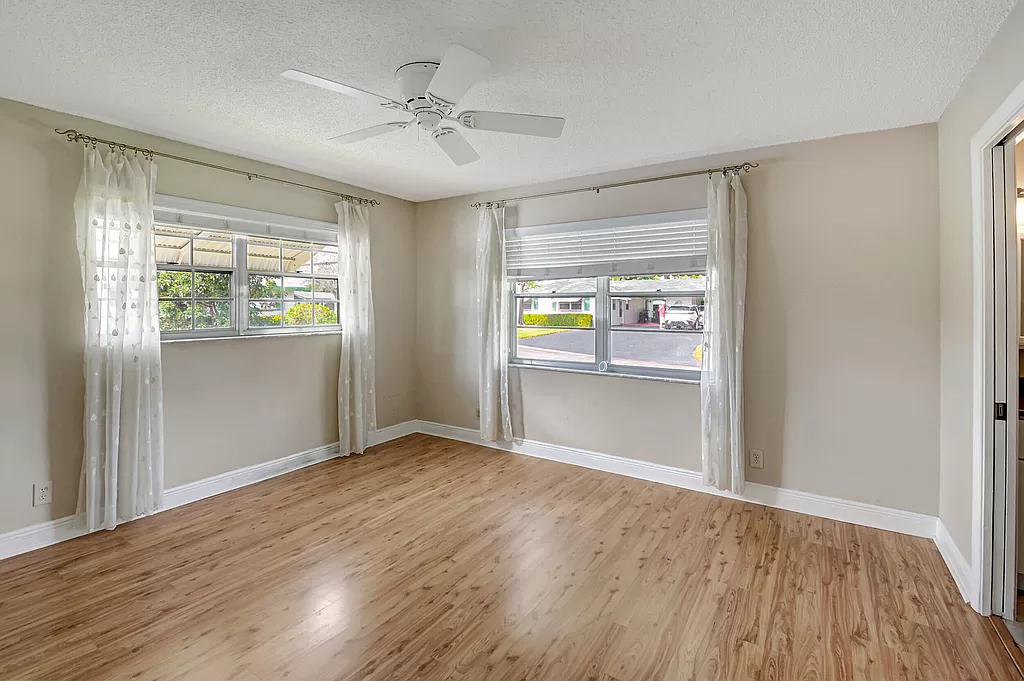

In [38]:
zips = os.listdir(IMAGES_DIR)
fn = os.path.join(IMAGES_DIR, zips[0], os.listdir(os.path.join(IMAGES_DIR, zips[0]))[0])
img = Image.open(fn)
img

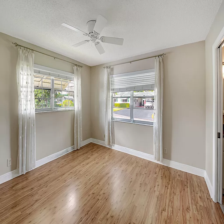

In [39]:
t = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image = t(img)
image

In [40]:
t = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: img.convert("RGB")),  # in case of transparency
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image = t(img)
image

tensor([[[0.6824, 0.6902, 0.6824,  ..., 0.7098, 0.6745, 0.6510],
         [0.6824, 0.6902, 0.6824,  ..., 0.7098, 0.6667, 0.6510],
         [0.6863, 0.6902, 0.6902,  ..., 0.6980, 0.6549, 0.6510],
         ...,
         [0.4824, 0.4941, 0.5216,  ..., 0.4745, 0.4353, 0.4314],
         [0.5176, 0.5333, 0.5373,  ..., 0.4431, 0.4588, 0.3882],
         [0.5255, 0.5373, 0.5804,  ..., 0.4275, 0.4549, 0.4157]],

        [[0.6863, 0.6941, 0.6863,  ..., 0.7020, 0.6706, 0.6431],
         [0.6863, 0.6902, 0.6863,  ..., 0.7020, 0.6588, 0.6431],
         [0.6902, 0.6941, 0.6941,  ..., 0.6902, 0.6471, 0.6431],
         ...,
         [0.3608, 0.3686, 0.4000,  ..., 0.3255, 0.2902, 0.3059],
         [0.3961, 0.4118, 0.4196,  ..., 0.2863, 0.3020, 0.2588],
         [0.4078, 0.4235, 0.4667,  ..., 0.2667, 0.3059, 0.2863]],

        [[0.6667, 0.6745, 0.6667,  ..., 0.6863, 0.6549, 0.6275],
         [0.6667, 0.6745, 0.6667,  ..., 0.6863, 0.6431, 0.6275],
         [0.6706, 0.6745, 0.6745,  ..., 0.6745, 0.6314, 0.

In [41]:
t = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda img: img.convert("RGB")),  # in case of transparency
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image = t(img)
image

tensor([[[ 0.8618,  0.8961,  0.8618,  ...,  0.9817,  0.8276,  0.7248],
         [ 0.8618,  0.8961,  0.8618,  ...,  0.9817,  0.7933,  0.7248],
         [ 0.8789,  0.8961,  0.8961,  ...,  0.9303,  0.7419,  0.7248],
         ...,
         [-0.0116,  0.0398,  0.1597,  ..., -0.0458, -0.2171, -0.2342],
         [ 0.1426,  0.2111,  0.2282,  ..., -0.1828, -0.1143, -0.4226],
         [ 0.1768,  0.2282,  0.4166,  ..., -0.2513, -0.1314, -0.3027]],

        [[ 1.0280,  1.0630,  1.0280,  ...,  1.0980,  0.9580,  0.8354],
         [ 1.0280,  1.0455,  1.0280,  ...,  1.0980,  0.9055,  0.8354],
         [ 1.0455,  1.0630,  1.0630,  ...,  1.0455,  0.8529,  0.8354],
         ...,
         [-0.4251, -0.3901, -0.2500,  ..., -0.5826, -0.7402, -0.6702],
         [-0.2675, -0.1975, -0.1625,  ..., -0.7577, -0.6877, -0.8803],
         [-0.2150, -0.1450,  0.0476,  ..., -0.8452, -0.6702, -0.7577]],

        [[ 1.1585,  1.1934,  1.1585,  ...,  1.2457,  1.1062,  0.9842],
         [ 1.1585,  1.1934,  1.1585,  ...,  1

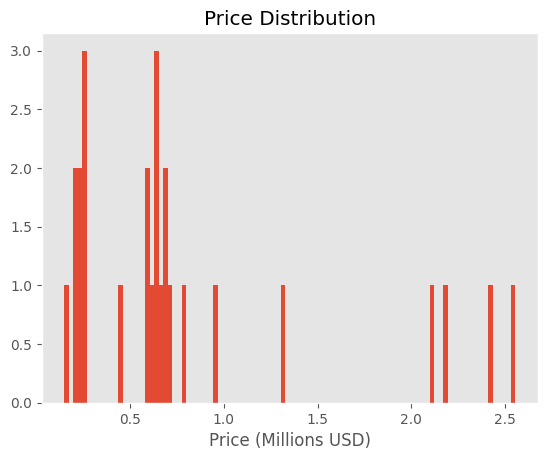

In [42]:
df = pd.read_csv(os.path.join(CLEANED_DIR, "meta.csv"))

(df["price"] / 1e6).hist(grid=False, bins=100)
plt.title("Price Distribution")
plt.xlabel("Price (Millions USD)")
plt.show()